This file takes all the information of the x and y that was obtained from 4_Method_to_Create_X_and_y_Training_Dataset and converts it into a balanced dataset for training. This means the following.

- Same instances of x input are combined.
- Each instance of x input has a set amount of samples.
    - This means shuffling and then taking random samples of the y targets to the set amount.
    - This is to avoid over fitting to set samples each epoch as they train on those with more samples.
- Each x and y is tiled to the amount of x inputs.
    - This makes is so that the batch size will train and update after training on a certain amount (1) of each x input to y target before updating the weights. 

In [1]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import random
import tensorflow as tf
import numpy as np
import timeit
from sklearn import metrics
import scipy.io as sio
import csv
import os
import math 
import random as rand
from numpy import genfromtxt
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import string

#import torch
#from torch import nn

import warnings
from scipy.spatial import distance


from importlib import reload
import sys
sys.path.append("../Imports/") # Adds higher directory to python modules path.

from Modules.Tools import MapTool
from Modules.Tools import BoxPlot
from Modules.Tools import Extractor
from Modules.Tools import peakCorrelation as pC
from Modules.Tools import ATmega2560_Instructions as Inst_Info
import time

# Notebook Parameters
- this is simply for obtaining the graphs with manual mapping. Pad is closely relate to the sampling rate for the EM signal.

In [2]:
save_folder = ""
load_signal_folder = "../Datasets/Signals/Numpy/segment_good/"
load_code_folder = "../Datasets/Instruction_Code/"
pad = 8
y_low=-2.8
y_high=2.8
amount=3200

# Load the Datasets

In [3]:
Train_Program_1_Code = np.load(load_code_folder + "Train_Program_1.npy").tolist()
Train_Program_2_Code = np.load(load_code_folder + "Train_Program_2.npy").tolist()
Train_Program_3_Code = np.load(load_code_folder + "Train_Program_3.npy").tolist()
Train_Program_4_Code = np.load(load_code_folder + "Train_Program_4.npy").tolist()

In [4]:
Train_Program_1 = np.load(load_signal_folder + "Train_Program_1.npy", allow_pickle=True)
Train_Program_2 = np.load(load_signal_folder + "Train_Program_2.npy", allow_pickle=True)
Train_Program_3 = np.load(load_signal_folder + "Train_Program_3.npy", allow_pickle=True)
Train_Program_4 = np.load(load_signal_folder + "Train_Program_4.npy", allow_pickle=True)

In [5]:
Code_for_Tokenizer = np.load("../Datasets/Tokenizer/Code_for_Tokenizer.npy")

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=100, char_level=False)

In [7]:
print(Code_for_Tokenizer)

['adc, add, brccF, brccT, brloF, brloT, clr, cp, cpi, dec, inc, ldi, mov, mul, rjmp, sbc, sub']


In [8]:
all_instructions = Code_for_Tokenizer[0]

sentence_Code = [all_instructions]
tokenizer.fit_on_texts(sentence_Code)

In [9]:
print(tokenizer.texts_to_sequences(sentence_Code))

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]]


In [11]:
print(tokenizer.texts_to_sequences(['brloF']))
print(tokenizer.texts_to_sequences(['ldi']))
print(tokenizer.texts_to_sequences(['adc']))
print(tokenizer.texts_to_sequences(['sbc']))

[[5]]
[[12]]
[[1]]
[[16]]


In [12]:
# Load the extracted information from the asm program code that was saved in 2_Extract_Important_Information
train_Set_Extracted = np.load("../Datasets/Extracted Information/train_Set_Extracted.npy", allow_pickle=True)

In [163]:
'''
Given lists of ASM_Inst, c_Values,  states of each Training Set in a list and a list of numpy arrays of sequence signals,

Input:
    train_Set_Extracted: list of ASM_Inst, list of c_Values, list of states of each Train_Program in that order.
    train_Set_Signals: list of numpy arrays of sequence signals. (must be in the same order as Train_Set_Extracted)
    sequence_size: sequence size of the number of instructions (prior instructions only) to consider.

Output:
    Sequence_Code: list of sequence code for each program executed in order of given Training_Set_Extracted.
    Register_Values: list of register values for each instruction in the each sequence for each program executed in order of give Training_Set_Extracted.
    Target_States: list of the state prior to executing the target instruction.
    Signal_Priors: list of signals corresponding to the prior instructions. 
        (Note: will be prior + 1 = same as sequence_size as Transformers need the prior signal to generate a new signal of same shape.
            This new signal will include some of the prior signal with added new generated time index values/amplitudes)
'''
def extractInformationFromTrainingSets(train_Set_Extracted, train_Set_Codes, sequence_size, tokenizer,
                                       include_c_Values=True, include_States=True, pad = 7, set_length = 35, amount = 3000, 
                                       to_Tokenize=True):
    x_repeats = []
    y_repeats = []
    start_peak = -2
    end_peak = 1
    
    # First obtain the Sequence_Code, Register_Values and Target_States
    ## cycle through each training set
    for t in range(train_Set_Extracted.shape[0]):
        train_Set = train_Set_Extracted[t]
        train_Code = train_Set_Codes[t]
        
        # Adjust how much to skip at the start for each cycle that is a prior instruction for first target instruction.
        for i in range(sequence_size):
            prior_inst = train_Code[i]
            amount_Cycles = Inst_Info.getCycles(prior_inst)
            for n in range(amount_Cycles):
                start_peak = start_peak + 2
                end_peak = end_peak +2
        
        ## Obtain the assembly instructions (ASM_Inst), current values (c_Values), and states.
        ASM_Inst, c_Values, states = train_Set
        
        ## Cycle though each instance
        for i in range(len(ASM_Inst)-sequence_size):
            info=[]
            target = ""
            ## Cycle through sequence_size
            for n in range(sequence_size+1):
                ## obtain the instruction in the sequence
                if to_Tokenize:
                    ASM = [ASM_Inst[i+n]][0]
                    if "-t" in ASM:
                        ASM = ASM[:-2] + "T"
                    elif "-f" in ASM:
                        ASM = ASM[:-2] + "F"
                    
                    info.append(tokenizer.texts_to_sequences([ASM])[0][0])
                else:
                    info.append(ASM_Inst[i+n])
                target = ASM_Inst[i+n]

                ## obtain current values before executing each instruction in the sequence
                if include_c_Values:
                    info.append(c_Values[i-n][0])
                    info.append(c_Values[i-n][1])
                    
            ## Add the state before executing the target instruction
            if include_States:
                info = info + states[i+sequence_size]
                
            ## Since the model generates cycles (2 waves) at a time, we need to check how many cycles the target instruction
            ## has and also add the info for each cycle along with an indicator on which cycle to generate.
            #print(target)
            #print(Inst_Info.getCycles(target))
            amount_Cycles = Inst_Info.getCycles(target)
            for i in range(amount_Cycles):
                info_cycle = info.copy()
                info_cycle.append(i+1)
                x_repeats.append(info_cycle)
                
        print(len(x_repeats))
            
    return x_repeats

In [15]:
train_Set_Codes = []
train_Set_Codes.append(Train_Program_1_Code)
train_Set_Codes.append(Train_Program_2_Code)
train_Set_Codes.append(Train_Program_3_Code)
train_Set_Codes.append(Train_Program_4_Code)
train_Set_Codes = np.array(train_Set_Codes, dtype=object)

In [165]:
x_Train_Program_1 = extractInformationFromTrainingSets(train_Set_Extracted, train_Set_Codes,sequence_size=2, 
                                         tokenizer=tokenizer, pad = pad,to_Tokenize=True)

180
374
545
678


196

In [143]:
x_Train_Programs = np.array(x_Train_Program_1)

In [147]:
y_Train_Program_1 = np.load("../Datasets/Cycle Signals/y_Train_Program_1_No_Offset.npy", allow_pickle = True)
y_Train_Program_2 = np.load("../Datasets/Cycle Signals/y_Train_Program_2_No_Offset.npy", allow_pickle = True)
y_Train_Program_3 = np.load("../Datasets/Cycle Signals/y_Train_Program_3_No_Offset.npy", allow_pickle = True)
y_Train_Program_4 = np.load("../Datasets/Cycle Signals/y_Train_Program_4_No_Offset.npy", allow_pickle = True)

In [148]:
print(x_Train_Programs.shape)
print(y_Train_Program_1.shape)
print(y_Train_Program_2.shape)
print(y_Train_Program_3.shape)
print(y_Train_Program_4.shape)

(678, 42)
(183, 2500, 38)
(196, 2500, 38)
(174, 2500, 38)
(135, 2500, 38)


# note: must remove the amount of cycles the first few instructions have for the amount of prior instructions to account for.

In [152]:
y_Train_Program_1 = y_Train_Program_1[3:]
y_Train_Program_2 = y_Train_Program_2[2:]
y_Train_Program_3 = y_Train_Program_3[3:]
y_Train_Program_4 = y_Train_Program_4[2:]

In [153]:
print(x_Train_Programs.shape)
print(y_Train_Program_1.shape)
print(y_Train_Program_2.shape)
print(y_Train_Program_3.shape)
print(y_Train_Program_4.shape)

(678, 42)
(180, 2500, 38)
(194, 2500, 38)
(171, 2500, 38)
(133, 2500, 38)


In [154]:
180 + 194 + 171 + 133

678

In [156]:
y_Train_Programs = np.concatenate((y_Train_Program_1, y_Train_Program_2), axis=0)
y_Train_Programs = np.concatenate((y_Train_Programs, y_Train_Program_3), axis=0)
y_Train_Programs = np.concatenate((y_Train_Programs, y_Train_Program_4), axis=0)

In [158]:
print(y_Train_Programs.shape)

(678, 2500, 38)


# Create the method

In [159]:
def Convert2BalanceTrainDataset(x, y, amount=3000, random_seed = 20):
    random.seed(random_seed)
    
    new_X = [x[0].tolist()]
    new_Y = [y[0].tolist()]
    
    first = 0
    # Remove repeatative x inputs.
    for i in range(x.shape[0]-2):
        if x[i+1].tolist() in new_X:
            #print("X input seen before: ", x[i+1])
            index = new_X.index(x[i+1].tolist())
            new_Y[index] = new_Y[index] + y[i+1].tolist()
            #print(x[i+1].tolist())
            #print(len(new_Y[index]))
            
        else:
            new_X.append(x[i+1].tolist())
            new_Y.append(y[i+1].tolist())
            
    # Shuffle all that is past the set amount and take only the set amount.
    ## This randomly takes samples of the given x_input
    for i in range(len(new_Y)):
        #random.shuffle(new_Y[i])
        if len(new_Y[i]) > amount:
            new_Y[i] = new_Y[i][:amount]
            
    
    # Now we need to tile and have a x for every y.
    ## tile x
    new_X = np.tile(new_X, (2500, 1))
    
    new_new_Y = []
    for i in range(2500):
        for a_list in new_Y:
            new_new_Y.append(a_list[i])
            
    del new_Y
            
    return np.array(new_X), np.array(new_new_Y, dtype=object)

In [32]:
list_of_lists = [[1, 2], [3, 4], [5, 6]]
value_to_check = [3, 4]

# Check if value_to_check is in the list of lists
if value_to_check in list_of_lists:
    index = list_of_lists.index(value_to_check)
    print(f"{value_to_check} is in the list of lists at index {index}.")
else:
    print(f"{value_to_check} is not in the list of lists.")

[3, 4] is in the list of lists at index 1.


In [119]:
temp = []
for i in range(new_Y.shape[1]):
    for a in range(new_Y.shape[0]):
        temp.append(new_Y[a][i])
temp = np.array(temp)

In [120]:
temp.shape

(402500, 38)

In [92]:
new_Y[0][0].shape

(38,)

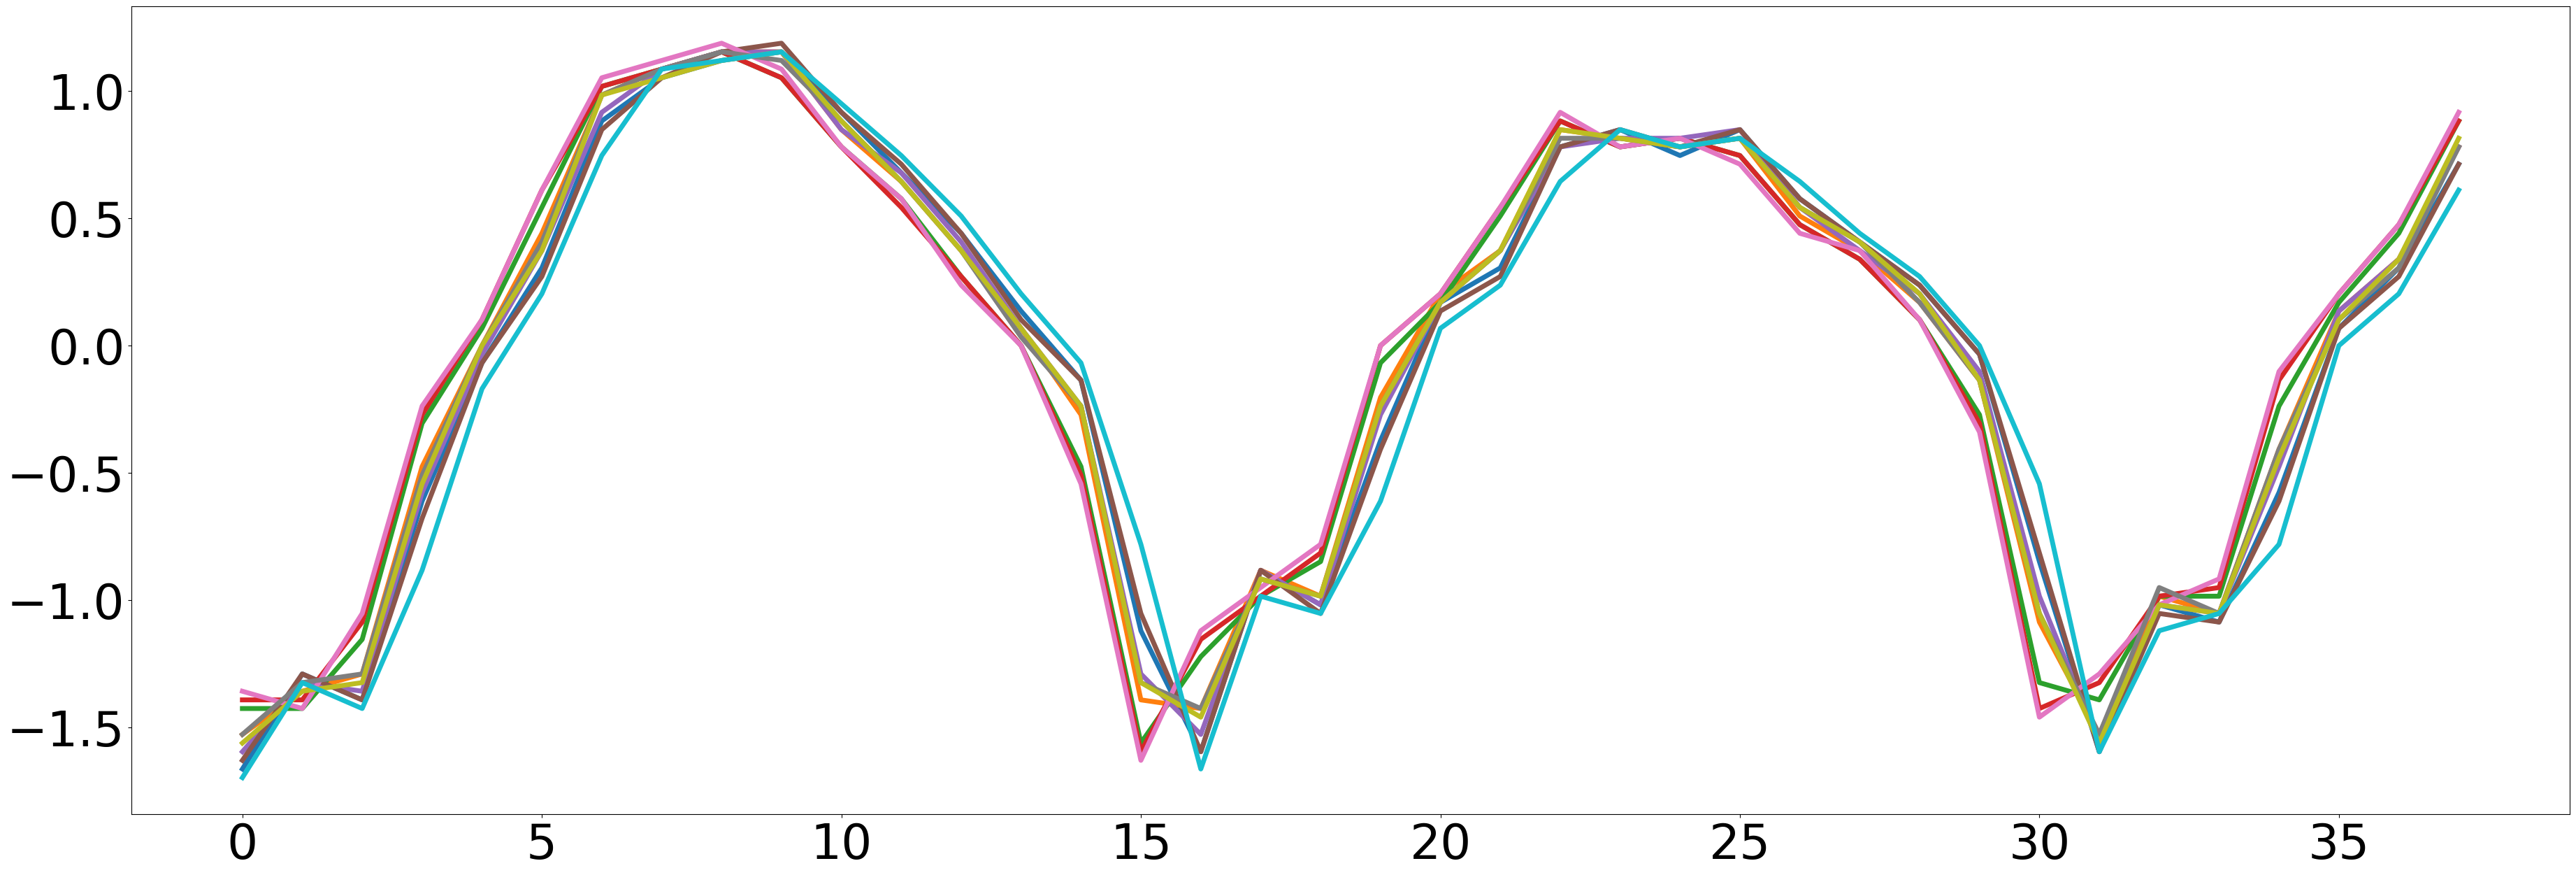

In [123]:
inst = 160
amount = 10

for n in range(amount):
    plt.plot(temp[inst + (161*n)])

In [160]:
new_X, new_Y = Convert2BalanceTrainDataset(x_Train_Programs, y_Train_Programs, amount=2500)

In [161]:
print(new_X.shape)
print(new_Y.shape)

(1662500, 42)
(1662500, 38)


In [108]:
temp = np.tile(new_X, (2500, 1))
temp.shape

(402500, 36)

In [75]:
2500 * 161

402500

In [109]:
inst = 160
for i in range(10):
    print(temp[inst + (161* i)])

[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[15 -1 -1  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  3  4 24 83
 83  6 13  0 99  0  0  0  0  0  0  1]
[

In [99]:
print(new_X.shape)
print(new_Y.shape)

(402500, 36)
(402500, 38)


In [34]:
print(new_X.shape)
print(new_Y.shape)

(161, 36)
(161, 2500, 38)


In [35]:
print(y_Train_Program_1.shape)

(183, 2500, 38)


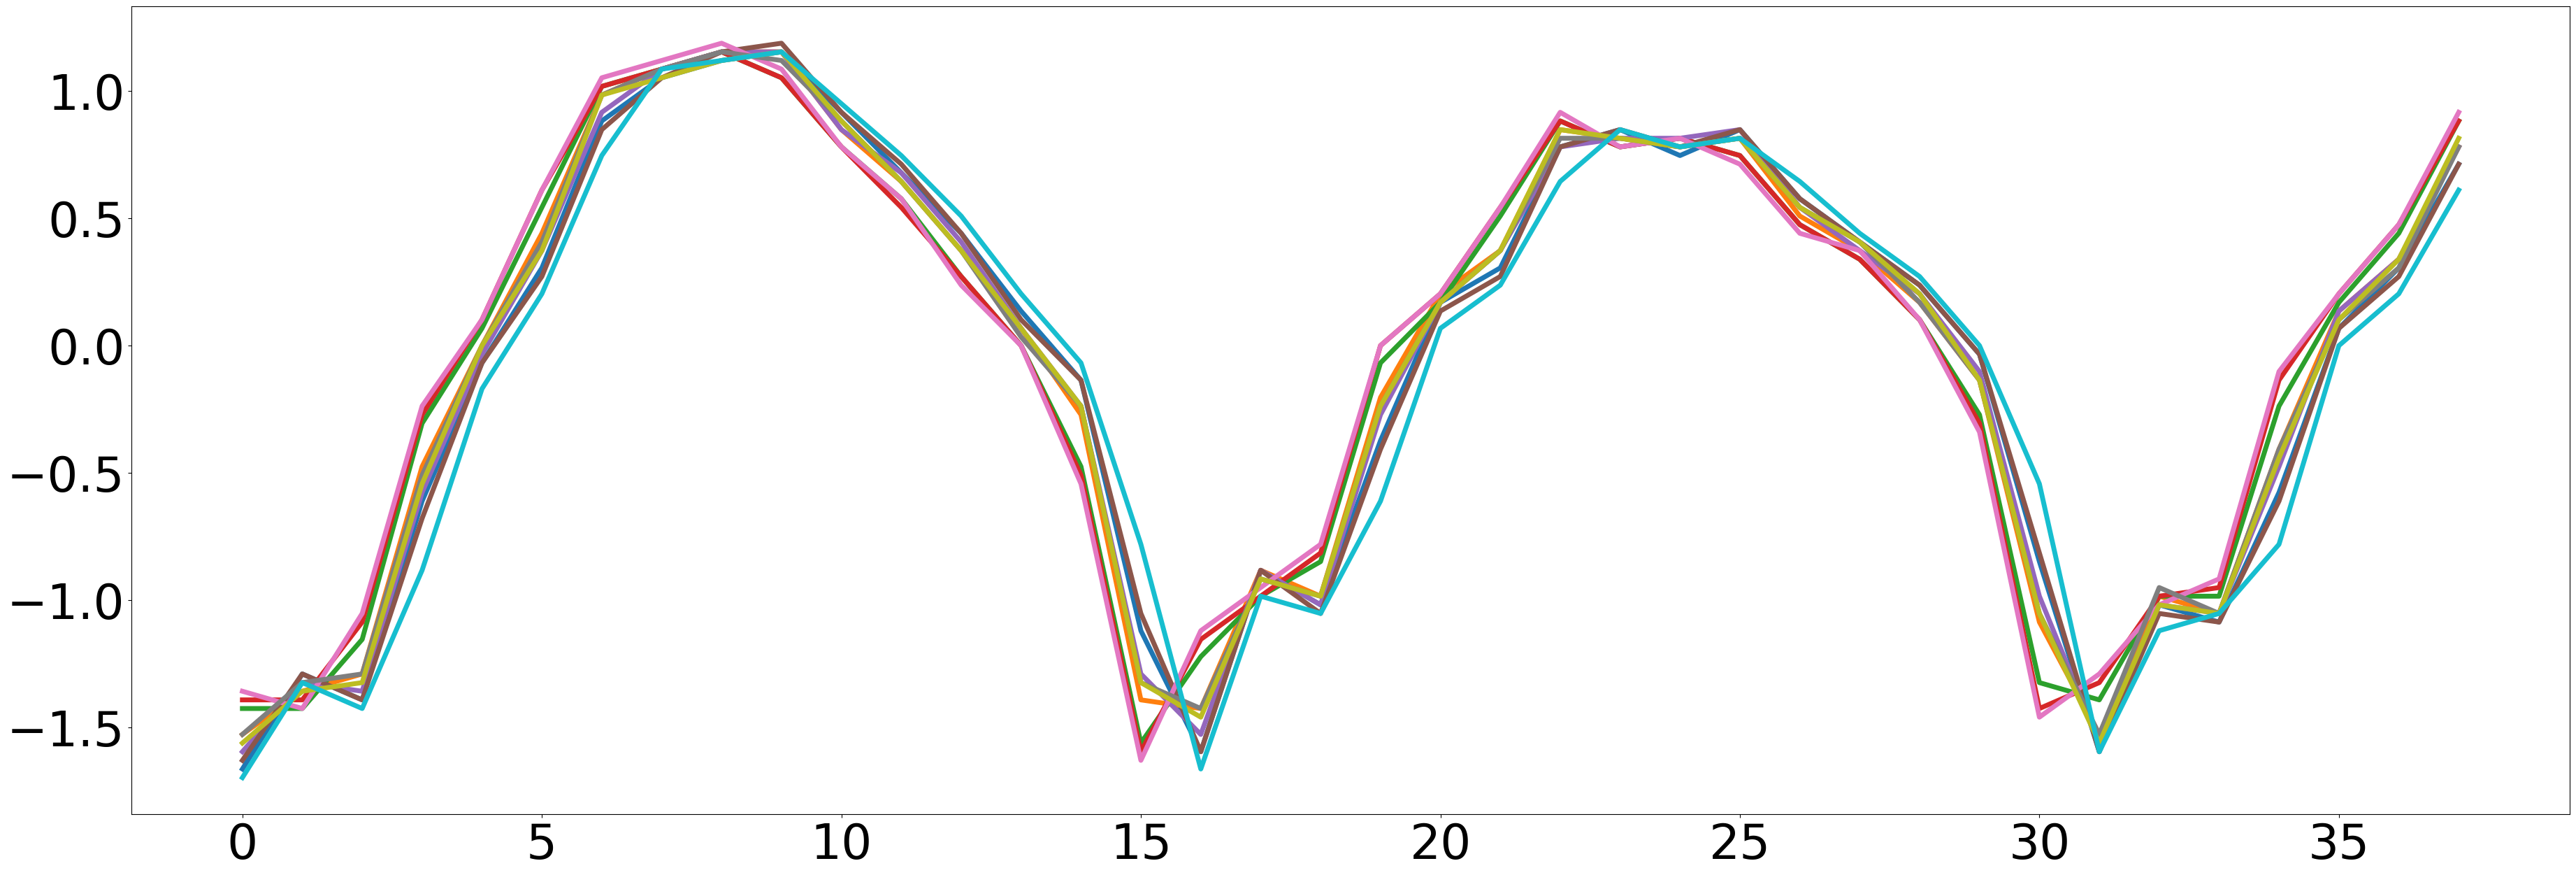

In [117]:
# Checker
cycle = 160
amount = 10

for n in range(amount):
    plt.plot(new_Y[cycle][n])

In [118]:
new_Y.shape

(161, 2500, 38)

In [45]:
peaks = MapTool.getPeaksDataset(new_Y[10], pad)

In [49]:
for p in range(len(peaks)):
    if peaks[p][0] < peaks[p][1]:
        print("Location: ", p)